<a href="https://colab.research.google.com/github/guilhermeterenciani/IA/blob/main/lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 43460353.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:

ds.targets = np.array(ds.targets)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

bs = 64
train_idx, temp_idx = train_test_split(np.arange(len(ds)),test_size=0.3,shuffle=True,stratify=ds.targets)
valid_idx, test_idx = train_test_split(temp_idx,test_size=0.5,shuffle=True,stratify=ds.targets[temp_idx])

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler  = torch.utils.data.SubsetRandomSampler(test_idx)

dl_train = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=train_sampler)
dl_valid = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=valid_sampler)
dl_test  = torch.utils.data.DataLoader(ds,batch_size=bs,sampler=test_sampler)

In [ ]:
np.unique(ds.targets,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

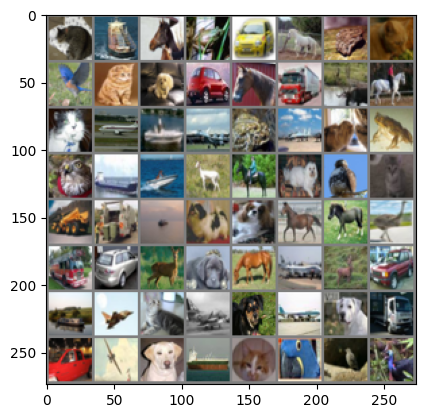

cat   ship  horse frog  car   horse frog  cat   bird  cat   dog   car   horse truck deer  horse cat   plane ship  plane frog  plane cat   frog  bird  ship  ship  deer  horse dog   bird  cat   truck truck ship  dog   dog   horse horse bird  truck car   deer  dog   horse plane deer  car   ship  plane cat   plane dog   plane dog   truck car   plane dog   ship  cat   bird  bird  bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dl_train)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(bs)))

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


In [ ]:
# congelar as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.fc.weight.size()

torch.Size([1000, 2048])

In [ ]:
class LORA(nn.Module):
    def __init__(self,adapted_layer,rank=20):
        super(LORA,self).__init__()
        self.layer = adapted_layer
        out_size = adapted_layer.weight.size(0)
        in_size  = adapted_layer.weight.size(1)
        self.a     = nn.Parameter(torch.randn(in_size,rank))
        self.b     = nn.Parameter(torch.zeros(rank,out_size))
    def forward(self,x):
        delta_weight = self.a@self.b
        new_weight   = self.layer.weight + delta_weight.t()
        return nn.functional.linear(x,new_weight,self.layer.bias)


In [ ]:
model.fc = LORA(model.fc)
#model.fc = nn.Linear(model.fc.in_features,10)

In [ ]:
from torch.optim import lr_scheduler


num_epochs = 20

# Check if CUDA (GPU support) is available and use it; otherwise, fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)


# Track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Implement a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_val_accuracy = 0.0
best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dl_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()  # Adjust the learning rate based on the scheduler
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(dl_train))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dl_valid:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_running_loss / len(dl_valid))
    val_accuracies.append(val_accuracy)

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = model.state_dict()

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(dl_train)}, Train Accuracy: {train_accuracy}%, Val Loss: {val_running_loss / len(dl_valid)}, Val Accuracy: {val_accuracy}%')

Epoch 1, Train Loss: 3.945007941404688, Train Accuracy: 33.15428571428571%, Val Loss: 2.692373230295666, Val Accuracy: 38.74666666666667%
Epoch 2, Train Loss: 2.4912740240585216, Train Accuracy: 38.66285714285714%, Val Loss: 2.6623567554910306, Val Accuracy: 40.24%
Epoch 3, Train Loss: 2.4024733036919965, Train Accuracy: 39.854285714285716%, Val Loss: 2.7444152670391535, Val Accuracy: 38.666666666666664%
Epoch 4, Train Loss: 2.3421933391630323, Train Accuracy: 40.56%, Val Loss: 2.6663915242178966, Val Accuracy: 40.13333333333333%
Epoch 5, Train Loss: 2.3135891989336588, Train Accuracy: 41.32857142857143%, Val Loss: 2.4054788926900446, Val Accuracy: 41.373333333333335%
Epoch 6, Train Loss: 2.3004082354156803, Train Accuracy: 41.15428571428571%, Val Loss: 2.33582807294393, Val Accuracy: 42.17333333333333%
Epoch 7, Train Loss: 2.2748192871292505, Train Accuracy: 41.90857142857143%, Val Loss: 2.6049421813528415, Val Accuracy: 39.36%
Epoch 8, Train Loss: 1.4360992102126098, Train Accuracy: 

KeyboardInterrupt: 

In [ ]:
Epoch 1, Train Loss: 1.7608865817678476, Train Accuracy: 39.89714285714286%, Val Loss: 1.621394778712321, Val Accuracy: 45.48%
Epoch 2, Train Loss: 1.5438399288728424, Train Accuracy: 47.54857142857143%, Val Loss: 1.5314354330806408, Val Accuracy: 48.693333333333335%
Epoch 3, Train Loss: 1.4977748465930305, Train Accuracy: 49.037142857142854%, Val Loss: 1.488418283098835, Val Accuracy: 49.81333333333333%
Epoch 4, Train Loss: 1.4627806205418254, Train Accuracy: 49.97142857142857%, Val Loss: 1.4681142507973364, Val Accuracy: 49.88%
Epoch 5, Train Loss: 1.4337083914162254, Train Accuracy: 50.94857142857143%, Val Loss: 1.434726633257785, Val Accuracy: 51.74666666666667%
Epoch 6, Train Loss: 1.4127299910925424, Train Accuracy: 51.70857142857143%, Val Loss: 1.4727802498865936, Val Accuracy: 50.86666666666667%
Epoch 7, Train Loss: 1.3892375021573613, Train Accuracy: 52.254285714285714%, Val Loss: 1.4197151691226635, Val Accuracy: 51.72%
Epoch 8, Train Loss: 1.354642448194284, Train Accuracy: 53.8%, Val Loss: 1.3959193906541598, Val Accuracy: 52.25333333333333%
Epoch 9, Train Loss: 1.354427363798431, Train Accuracy: 53.51714285714286%, Val Loss: 1.3929452118227037, Val Accuracy: 53.026666666666664%
Epoch 10, Train Loss: 1.3494925788813144, Train Accuracy: 54.22571428571428%, Val Loss: 1.406822677386009, Val Accuracy: 52.413333333333334%
Epoch 11, Train Loss: 1.3471369987432003, Train Accuracy: 53.92285714285714%, Val Loss: 1.4006034044896143, Val Accuracy: 52.626666666666665%
Epoch 12, Train Loss: 1.3420888928652246, Train Accuracy: 54.36571428571428%, Val Loss: 1.3776854610039015, Val Accuracy: 52.81333333333333%
Epoch 13, Train Loss: 1.3419486526161486, Train Accuracy: 54.19428571428571%, Val Loss: 1.3913407830868738, Val Accuracy: 52.36%
Epoch 14, Train Loss: 1.340001270038772, Train Accuracy: 54.151428571428575%, Val Loss: 1.383038080344766, Val Accuracy: 52.96%
Epoch 15, Train Loss: 1.337984880102182, Train Accuracy: 54.24285714285714%, Val Loss: 1.3828545359231659, Val Accuracy: 52.653333333333336%
Epoch 16, Train Loss: 1.3364371625771252, Train Accuracy: 54.348571428571425%, Val Loss: 1.3854908983586198, Val Accuracy: 53.16%
Epoch 17, Train Loss: 1.3353341504032477, Train Accuracy: 54.308571428571426%, Val Loss: 1.3889800593004389, Val Accuracy: 52.53333333333333%
Epoch 18, Train Loss: 1.338541005603574, Train Accuracy: 54.174285714285716%, Val Loss: 1.389190528857506, Val Accuracy: 52.85333333333333%
E